检测到 2 个样本。


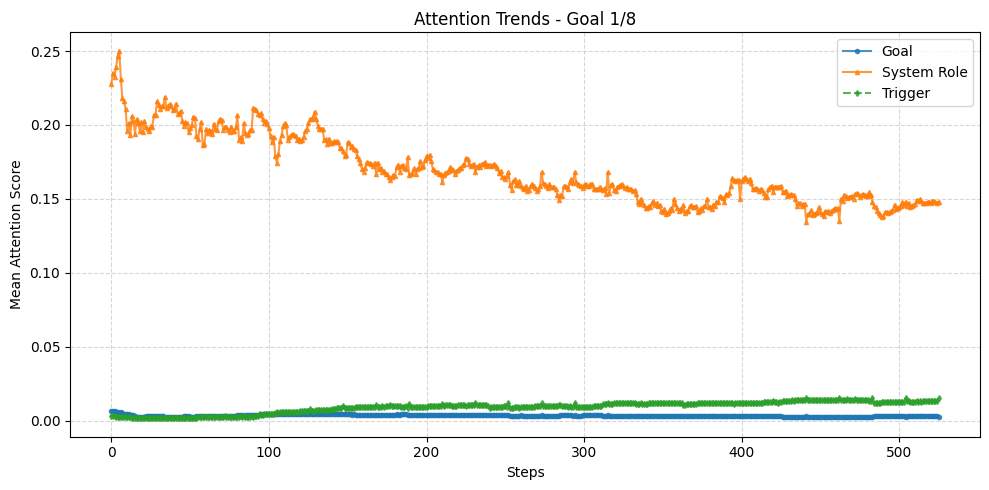

✅ Goal 1/8: 已绘制 526 步数据。


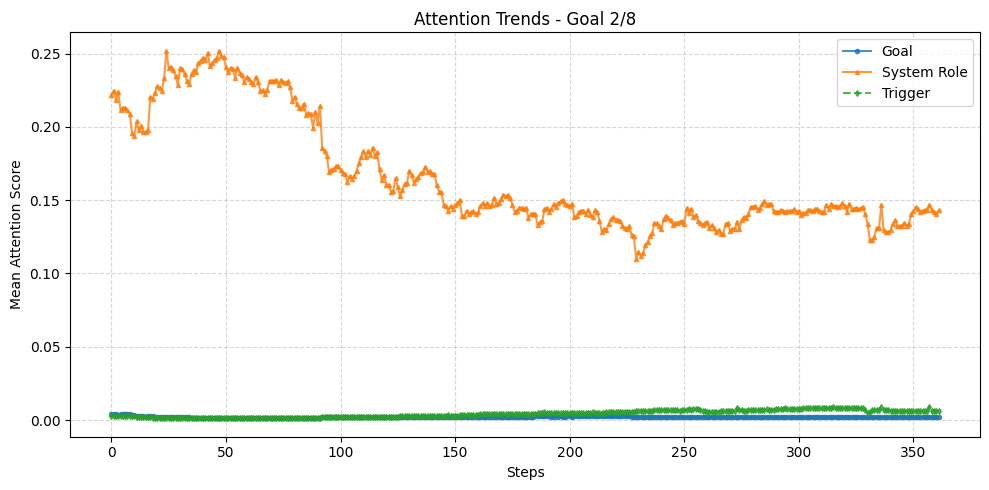

✅ Goal 2/8: 已绘制 362 步数据。


In [9]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os

# 你的日志文件路径
log_file_path = "/home/dataset/2024_zox_llm/code/AttnGCG-attack/experiments/bash_scripts/out_gemma_2b_attngcg_direct/0_20251223_143532.out" 

def parse_and_plot_separated_samples(file_path):
    # 1. 读取文件
    if not os.path.exists(file_path):
        print(f"错误: 找不到文件 '{file_path}'")
        return

    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read()

    # 2. 按 Goal 切分样本
    sample_pattern = r"(Goal\s+(\d+)/(\d+).*?)(?=Goal\s+\d+/\d+|$)"
    samples_raw = list(re.finditer(sample_pattern, content, re.DOTALL))
    
    if not samples_raw:
        print("未检测到明显的 'Goal X/Y' 分隔符，尝试将整个文件作为一个样本处理...")
        samples_raw = [re.search(r"()", content)] # Dummy match
        sample_names = ["Single Sample"]
        sample_contents = [content]
    else:
        print(f"检测到 {len(samples_raw)} 个样本。")
        sample_names = []
        sample_contents = []
        for match in samples_raw:
            # 提取 Goal 标题 (例如 "Goal 1/8")
            header_match = re.search(r"Goal\s+(\d+)/(\d+)", match.group(1))
            if header_match:
                name = f"Goal {header_match.group(1)}/{header_match.group(2)}"
            else:
                name = f"Sample {len(sample_names)+1}"
            
            sample_names.append(name)
            sample_contents.append(match.group(0))

    # 3. 定义 Attention 数据提取正则 (已更新以包含 Trigger)
    # 说明：最后的 (?: ... )? 是非捕获组，表示 Trigger 部分是可选的，防止旧日志报错
    attn_pattern = (
        r"\[DEBUG Attn\] goal\(min=.*?, mean=([\d\.]+)\)\s*\|\s*"
        r"sys_role\(min=.*?, mean=([\d\.]+)\)\s*\|\s*"
        r"control\(min=.*?, mean=([\d\.]+)\)"
        r"(?:\s*\|\s*trigger\(min=.*?, mean=([\d\.]+)\))?" 
    )

    # 4. 遍历每个样本进行解析和绘图
    for i, (name, raw_text) in enumerate(zip(sample_names, sample_contents)):
        data = []
        for match in re.finditer(attn_pattern, raw_text):
            groups = match.groups()
            goal_mean = groups[0]
            sys_role_mean = groups[1]
            control_mean = groups[2]
            trigger_mean = groups[3] # 如果没有匹配到 trigger，这里会是 None

            row = {
                "Goal": float(goal_mean),
                "System Role": float(sys_role_mean),
                "Control (Suffix)": float(control_mean)
            }
            
            # 如果存在 Trigger 数据，则添加
            if trigger_mean is not None:
                row["Trigger"] = float(trigger_mean)
            else:
                # 为了保持绘图连续性，如果没有 trigger 可以设为 0 或 NaN，或者仅仅不添加该列
                row["Trigger"] = 0.0 

            data.append(row)
        
        if not data:
            print(f"⚠️ {name}: 未提取到 Attention 数据，跳过绘图。")
            continue
            
        df = pd.DataFrame(data)
        
        # --- 绘图 ---
        plt.figure(figsize=(10, 5))
        
        # 绘制原有曲线
        plt.plot(df.index, df["Goal"], label="Goal", marker='o', markersize=3, alpha=0.8)
        plt.plot(df.index, df["System Role"], label="System Role", marker='^', markersize=3, alpha=0.8)
        # plt.plot(df.index, df["Control (Suffix)"], label="Control", marker='s', markersize=3, alpha=0.8)
        
        # 如果 Trigger 列有非零数据，则绘制
        if "Trigger" in df.columns and df["Trigger"].any():
            plt.plot(df.index, df["Trigger"], label="Trigger", marker='d', markersize=3, alpha=0.8, linestyle='--')
        
        plt.title(f"Attention Trends - {name}")
        plt.xlabel("Steps")
        plt.ylabel("Mean Attention Score")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        print(f"✅ {name}: 已绘制 {len(df)} 步数据。")

if __name__ == "__main__":
    parse_and_plot_separated_samples(log_file_path)